In [1]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn import preprocessing
# Import sklearn 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression

import pickle
from collections import Counter

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)


#from altair import Chart, X, Y, Axis, SortField

#pd.options.display.max_rows = 100
#pd.options.display.max_columns = 100
#pd.options.display.float_format = '{:.1f}'.format

%matplotlib inline

import matplotlib.pyplot as plt
import warnings
import itertools
import operator
import statsmodels.api as sm

# Source of the dataset
## http://archive.ics.uci.edu/ml/machine-learning-databases/

In [2]:
retail = pd.read_csv('online_retail.csv')
retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Data Understanding
InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
Description: Product (item) name. Nominal.
Quantity: The quantities of each product (item) per transaction. Numeric.
InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
UnitPrice: Unit price. Numeric, Product price per unit in sterling.
CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
Country: Country name. Nominal, the name of the country where each customer resides.

In [3]:
retail['InvoiceDate'] =  pd.to_datetime(retail['InvoiceDate'])
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
# checking for missing values
retail.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [5]:
Retail=retail.dropna()

In [6]:
Retail.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [7]:
# check duplicates

print('Number of duplicated records: ', Retail.duplicated(keep='first').sum())

Number of duplicated records:  5225


In [8]:
#Drop duplicates

indx = Retail[Retail.duplicated(keep='first')].index
Retail.drop(index = indx, inplace= True)
Retail.shape

C:\Users\STSC\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(401605, 8)

In [9]:
# Drop cancelled transactions
indx = Retail.Invoice[Retail.Invoice.str.contains('C') == True].index
Retail.drop(index= indx, inplace= True)
Retail.shape

(392733, 8)

In [10]:
# Drop transactions with price zero
indx = Retail.loc[Retail.Price == 0].index
Retail.drop(index= indx, inplace= True)
Retail.shape

(392693, 8)

In [11]:
# Changing the datatype of Customer Id as per Business understanding

Retail['Customer ID'] = Retail['Customer ID'].astype(str)

C:\Users\STSC\AppData\Local\Temp/ipykernel_10944/4142388735.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
# Amount per transaction which is the product of sale price and quantity
Retail['TotalSales'] = Retail['Price'] * Retail['Quantity']
Retail['TotalSales'].head()
Retail.head()

C:\Users\STSC\AppData\Local\Temp/ipykernel_10944/2834976445.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalSales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


# Further exploration on Description of the Product

In [13]:
# general clean up of Description column to remove any heading or trailing white space
Retail['Description'] = Retail['Description'].str.strip()
descriptors = pd.unique(Retail['Description'].values.ravel()).tolist()
print('There are',len(descriptors), 'unique descriptors in the Descriptions column.')

There are 3866 unique descriptors in the Descriptions column.


C:\Users\STSC\AppData\Local\Temp/ipykernel_10944/1232925765.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
descriptors2 = []
for i in range(0,len(descriptors),1):
    text = str(descriptors[i])
    if text == text.upper():
        descriptors2.append(text)
        
print('There are', len(descriptors2), 'all caps descriptors.')

There are 3845 all caps descriptors.


In [15]:
# from inspection of the baskets below I identified 3 problem descriptors that need to be followed up.
additional_problem_list = ['damages/credits from ASOS.','incorrectly credited C550456 see 47', 'mystery! Only ever imported 1800']

In [16]:
# remove additional erroneous rows
Retail = Retail[~Retail['Description'].isin(additional_problem_list)]
Retail.shape

(392693, 9)

In [17]:
Invoice = pd.unique(Retail['Invoice'].values.ravel()).tolist()
print('There are', len(Invoice), 'unique invoice numbers in the dataset.')

There are 18532 unique invoice numbers in the dataset.


# Country wise informations

In [18]:
by_country = Retail.groupby('Country')
by_country.describe()

Quantity                                           \
                         count       mean         std  min    25%   50%   
Country                                                                   
Australia               1181.0  71.033870   98.781975  1.0  10.00  32.0   
Austria                  398.0  12.263819   21.590493  1.0   6.00  10.0   
Bahrain                   17.0  15.294118   24.959379  2.0   6.00   6.0   
Belgium                 2031.0  11.441162   13.597680  1.0   4.00  10.0   
Brazil                    32.0  11.125000    8.476723  2.0   3.00  10.0   
Canada                   151.0  18.298013   46.682587  1.0   6.00  12.0   
Channel Islands          747.0  12.697456   22.679124  1.0   4.00  10.0   
Cyprus                   603.0  10.514096   23.498096  1.0   2.00   6.0   
Czech Republic            25.0  26.840000   17.276381  1.0  18.00  24.0   
Denmark                  380.0  21.671053   27.399800  1.0  12.00  12.0   
EIRE                    7226.0  19.392887   41.504921  1.0   4.00  12.0   
European Community        60.0   8.316667    6.466319  1.0   3.75   6.0   
Finland                  685.0  15.626277   21.004606  1.0   6.00  10.0   
France                  8327.0  13.381650   21.115297  1.0   6.00  10.0   
Germany                 9025.0  13.202659   17.652026  1.0   6.00  10.0   
Greece                   145.0  10.737931    7.689297  1.0   6.00  10.0   
Iceland                  182.0  13.505495   18.856172  2.0   6.00  12.0   
Israel                   245.0  16.502041   16.328750  1.0   4.00  12.0   
Italy                    758.0  10.701847   13.609025  1.0   4.00   8.0   
Japan                    321.0  81.046729  181.006408  1.0  12.00  48.0   
Lebanon                   45.0   8.577778    4.314294  2.0   6.00   8.0   
Lithuania                 35.0  18.628571   10.137542  6.0  12.00  16.0   
Malta                    112.0   8.660714    7.805696  1.0   4.00   6.0   
Netherlands             2359.0  84.934718  110.726029  1.0  16.00  72.0   
Norway                  1071.0  18.054155   22.619999  1.0   6.00  12.0   
Poland                   330.0  11.163636   10.029313  1.0   4.00  10.0   
Portugal                1453.0  11.077082   11.871946  1.0   4.00  10.0   
RSA                       57.0   6.157895    3.288451  2.0   3.00   6.0   
Saudi Arabia               9.0   8.888889    3.887301  2.0   6.00  12.0   
Singapore                222.0  23.608108   27.846940  1.0   8.50  12.0   
Spain                   2479.0  11.267850   22.852442  1.0   3.00   6.0   
Sweden                   450.0  80.173333  128.681652  1.0   9.00  24.0   
Switzerland             1841.0  16.340033   18.859249  1.0   6.00  12.0   
USA                      179.0  13.731844   11.488423  1.0   6.00  12.0   
United Arab Emirates      68.0  14.441176   12.474909  1.0   6.00  12.0   
United Kingdom        349203.0  12.145672  190.628818  1.0   2.00   4.0   
Unspecified              241.0   7.406639    8.925653  1.0   1.00   2.0   

                                         Price             ...                 \
                        75%      max     count       mean  ...   75%      max   
Country                                                    ...                  
Australia             100.0   1152.0    1181.0   3.053133  ...  3.75   350.00   
Austria                12.0    288.0     398.0   4.256030  ...  4.15    40.00   
Bahrain                 8.0     96.0      17.0   4.644118  ...  4.95    12.75   
Belgium                12.0    272.0    2031.0   3.630158  ...  4.15    39.95   
Brazil                 18.0     24.0      32.0   4.456250  ...  6.75    10.95   
Canada                 20.0    504.0     151.0   6.030331  ...  2.95   550.94   
Channel Islands        12.0    407.0     747.0   4.535475  ...  5.95   293.00   
Cyprus                 12.0    288.0     603.0   5.748176  ...  4.95   320.69   
Czech Republic         24.0     72.0      25.0   3.130800  ...  2.55    40.00   
Denmark                24.0    256.0     380.0   

In [19]:
grouped  = Retail.groupby(['Country']).sum()['Quantity'].sort_values(ascending=False)

data_plot = [go.Bar(x=grouped.index, y=grouped.values)]
layout = go.Layout(yaxis={'type':'log', 'autorange':True, 'title':'Log10 number of orders'},xaxis={'title':'country'})
fig = go.Figure(data=data_plot, layout=layout)
iplot(fig)

C:\Users\STSC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



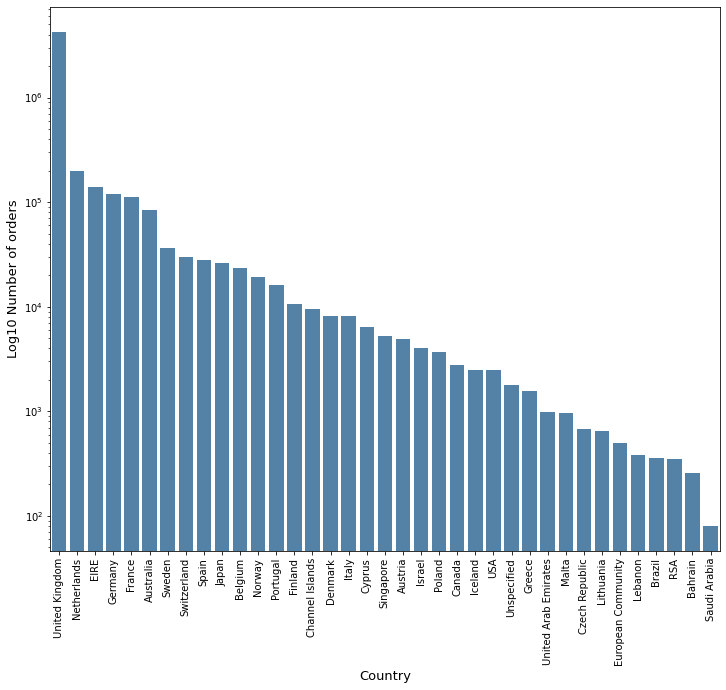

In [20]:
grouped  = Retail.groupby(['Country']).sum()['Quantity'].sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values, color='steelblue')
f.get_axes()[0].set_yscale('log') #I'm using a log scale just for visualisation as the UK dominates the market
plt.ylabel('Log10 Number of orders', fontsize=13)
plt.xlabel('Country', fontsize=13)
plt.show()

In [31]:
# group by customer ID and invoice number to create a basket per customer
temp = Retail.groupby(by=['Customer ID', 'Invoice'], as_index=False)['InvoiceDate'].count()
products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
products_per_basket[:10].sort_values('Number of products', ascending=False)

,Customer ID,Invoice,Number of products
6,12347.0,573511,47
1,12347.0,537626,31
2,12347.0,542237,29
3,12347.0,549222,24
5,12347.0,562032,22
4,12347.0,556201,18
8,12348.0,539318,17
7,12347.0,581180,11
9,12348.0,541998,6
0,12346.0,541431,1


In [32]:
print('There are:',Retail['Invoice'].str.contains("C").sum(), 'orders marked C, which contribute',(Retail['Invoice'].str.contains("C").sum()/len(Retail))*100, '% of the dataset.')

There are: 0 orders marked C, which contribute 0.0 % of the dataset.


In [33]:
# select all the cancelled orders
cancelled_orders = Retail[Retail.Invoice.str.contains("C")]
cancelled_orders.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalSales


In [34]:
#Invoice containing "C" character having negative Quantity value, assuming these are cancelled orders, so removing cancelled orders.
c1_tmp = pd.DataFrame(cancelled_orders['Invoice'])
c2_tmp = cancelled_orders['Invoice'].str.extract('(\d+)').astype(int)
c1_tmp['invoice2'] = c2_tmp


In [35]:
Retail = Retail[~Retail['Invoice'].isin(c1_tmp['Invoice'])]
Retail = Retail[~Retail['Invoice'].isin(c1_tmp['invoice2'])]

# The Top Customer ID basket

In [36]:
# group by customer ID to create a rank buyers by how many products they buy in total.
temp = Retail.groupby(by=['Customer ID'], as_index=False)['InvoiceDate'].count()
products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
top_baskets = products_per_basket.sort_values('Number of products', ascending=False)
top_baskets.head(10)

,Customer ID,Number of products
4010,17841.0,7676
1879,14911.0,5670
1289,14096.0,5111
326,12748.0,4412
1661,14606.0,2677
2176,15311.0,2366
1689,14646.0,2076
562,13089.0,1814
690,13263.0,1667
1434,14298.0,1637


In [37]:
grouped = top_baskets[:50]
grouped.reset_index(level=0, inplace=True)
grouped.sort_values('Number of products', ascending=False, inplace=True)
grouped['CustomerID'] = grouped['Customer ID'].astype(str)
data_plot = [go.Bar(x=grouped['Customer ID'], y=grouped['Number of products'])]
layout = go.Layout(yaxis={'autorange':True,'title':'Number of products in basket'},xaxis={'type':'category','title':'Customer ID'},title = 'number of products bought in the top50 largest baskets')
fig = go.Figure(data=data_plot, layout=layout)
iplot(fig)

C:\Users\STSC\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\STSC\AppData\Local\Temp/ipykernel_10944/2527199843.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



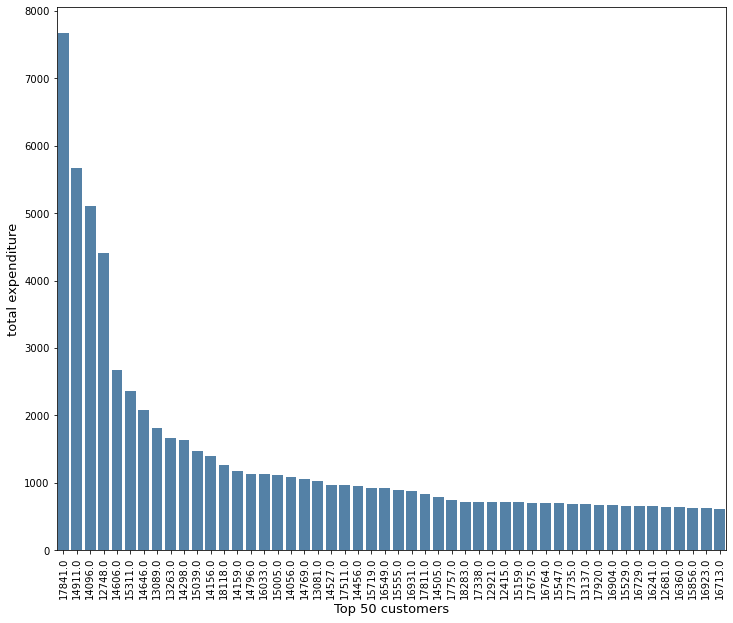

In [38]:
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(x=grouped['Customer ID'], y=grouped['Number of products'],order=grouped['Customer ID'],color='steelblue',ci=None)
plt.ylabel('total expenditure', fontsize=13)
plt.xlabel('Top 50 customers', fontsize=13)
plt.show()

In [39]:
top_basket = Retail[Retail['Customer ID'] == top_baskets['Customer ID'].iloc[0]]
top_basket #uncomment to view basket contents

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalSales
2037,536557,21495,SKULLS AND CROSSBONES WRAP,25,2010-12-01 14:41:00,0.42,17841.0,United Kingdom,10.50
2038,536557,46000R,POLYESTER FILLER PAD 45x30cm,2,2010-12-01 14:41:00,1.45,17841.0,United Kingdom,2.90
2039,536557,46000S,POLYESTER FILLER PAD 40x40cm,1,2010-12-01 14:41:00,1.45,17841.0,United Kingdom,1.45
2040,536557,22731,3D CHRISTMAS STAMPS STICKERS,1,2010-12-01 14:41:00,1.25,17841.0,United Kingdom,1.25
2041,536557,21258,VICTORIAN SEWING BOX LARGE,1,2010-12-01 14:41:00,12.75,17841.0,United Kingdom,12.75
...,...,...,...,...,...,...,...,...,...
537748,581334,22077,6 RIBBONS RUSTIC CHARM,1,2011-12-08 12:07:00,1.95,17841.0,United Kingdom,1.95
537749,581334,23399,HOME SWEET HOME HANGING HEART,3,2011-12-08 12:07:00,0.85,17841.0,United Kingdom,2.55
537750,581334,22893,MINI CAKE STAND T-LIGHT HOLDER,12,2011-12-08 12:07:00,0.42,17841.0,United Kingdom,5.04
537751,581334,22371,AIRLINE BAG VINTAGE TOKYO 78,1,2011-12-08 12:07:00,4.25,17841.0,United Kingdom,4.25


In [40]:
# Removing all unusual stock code
real = (~Retail['StockCode'].str.contains('[0-9]'))
unusual_stock_codes = Retail.loc[real] #filter out any stock codes that are numeric to leave the non-standard codes
unusual_stock_codes.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalSales
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583.0,France,54.00
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.00,12791.0,Netherlands,15.00
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.00,12662.0,Germany,18.00
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274.0,United Kingdom,1.25
2250,536569,M,Manual,1,2010-12-01 15:35:00,18.95,16274.0,United Kingdom,18.95


In [41]:
unusual_stock_codes['StockCode'].unique(), print('total number of these short stock code entries:',len(unusual_stock_codes))

Retail = Retail.loc[~real]

total number of these short stock code entries: 1410


In [42]:
#Invoice Date analysis
timestamp_list = list(Retail.InvoiceDate)
Timeframe = pd.DataFrame(pd.to_datetime(timestamp_list), columns=['time'])
Retail['time'] = Timeframe['time'].values
Retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalSales,time
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01 08:26:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01 08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01 08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01 08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01 08:26:00


# Feature engineering
Goal of our study is to visualize which products are the most popular products, which country saw the maximum sales, as well as in which weekday/month sales is maximum.Finally we conduct a Market Basket Analysis to find out which products are frequently bought together, so that relevant product recommendations can be provided to a customer who is interested in buying a particular item.

In [43]:
#the total amount spent per customers
TotalSales = Retail['Quantity'] * Retail['Price']
data = Retail.assign(TotalSales=TotalSales.values)
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalSales,time
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01 08:26:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01 08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01 08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01 08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01 08:26:00


In [44]:
#https://github.com/joaolcorreia/RFM-analysis
data['time'] = data['time'].dt.strftime('%Y-%m-%d')
data.rename(columns={'total_spend': 'grand_total'}, inplace=True)
data.to_csv('data4rfm.csv', sep=',', encoding='utf-8')
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalSales,time
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01


In [45]:
#Grouped per country

grouped = data.groupby(['Country']).sum()['TotalSales'].sort_values(ascending=False)
data_plot = [go.Bar(x=grouped.index, y=grouped.values)]
layout = go.Layout(yaxis={'autorange':True, 'title':'total order expenditure'},xaxis={'title':'country'},title="total spend per country")
fig = go.Figure(data=data_plot, layout=layout)
iplot(fig)

C:\Users\STSC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



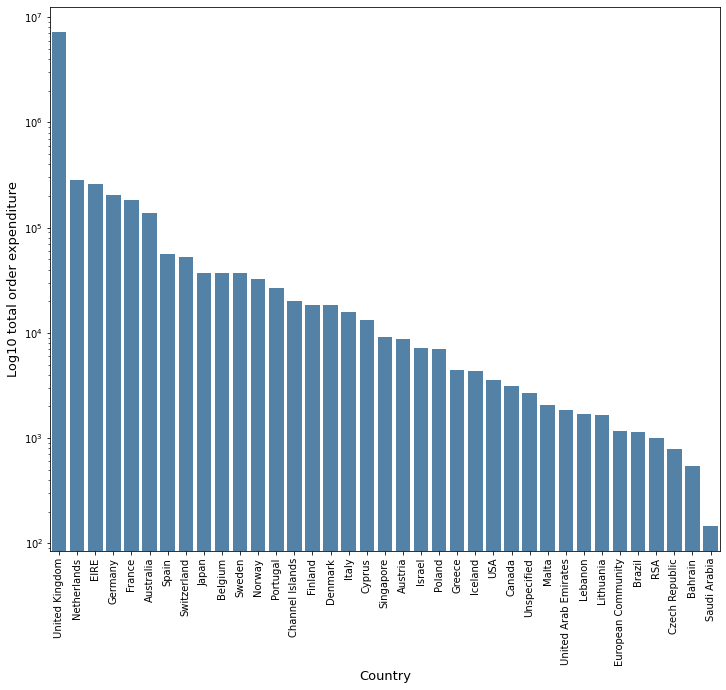

In [46]:
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values, color='steelblue')
f.get_axes()[0].set_yscale('log') #I'm using a log scale just for visualisation as the UK dominates the market
plt.ylabel('Log10 total order expenditure', fontsize=13)
plt.xlabel('Country', fontsize=13)
plt.show()

In [47]:
#Grouped per customer
grouped  = data.groupby(['Customer ID']).sum()['TotalSales'].sort_values(ascending=False)
grouped_top = pd.DataFrame(grouped.head(50))
grouped_top.reset_index(level=0, inplace=True)
grouped_top.sort_values('Customer ID', ascending=False)

#f, ax = plt.subplots(figsize=(12, 10))
#plt.xticks(rotation='vertical')
#sns.barplot(x=grouped_top['CustomerID'], y=grouped_top['total_spend'],order=grouped_top['CustomerID'],color='steelblue')
#plt.ylabel('total expenditure', fontsize=13)
#plt.xlabel('Top 50 customers', fontsize=13)
#plt.show()

data_plot = [go.Bar(x=grouped_top['Customer ID'], y=grouped_top['TotalSales'])]
layout = go.Layout(yaxis={'autorange':True,'title':'Top 50 customers'},xaxis={'type':'category','title':'total expenditure'})
fig = go.Figure(data=data_plot, layout=layout)
iplot(fig)

In [48]:
#the top 50 largest baskets, in terms of total spend
top_50 = data[data['Customer ID'].isin(grouped_top['Customer ID'])]
top50_tmp  = top_50.groupby(['Country']).sum()['TotalSales'].sort_values(ascending=False)

top50_tmp = pd.DataFrame(top50_tmp)
top50_tmp.reset_index(level=0, inplace=True)
top50_tmp.sort_values('Country', ascending=False)

data_plot = [go.Bar(x=top50_tmp['Country'], y=top50_tmp['TotalSales'])]
layout = go.Layout(yaxis={'autorange':True,'title':'total expenditure'},xaxis={'type':'category','title':'country'})
fig = go.Figure(data=data_plot, layout=layout)
iplot(fig)

#f, ax = plt.subplots(figsize=(12, 10))
#plt.xticks(rotation='horizontal')
#sns.barplot(x=top50_tmp['Country'], y=top50_tmp['total_spend'],order=top50_tmp['Country'],color='steelblue')
#plt.ylabel('total expenditure', fontsize=13)
#plt.xlabel('Top 50 customers', fontsize=13)
#plt.show()

# Top customers based on sale value

In [49]:
temp = data.groupby(by=['Customer ID', 'Invoice'], as_index=False)['TotalSales'].sum()
basket_price = temp.rename(columns = {'TotalSales':'Basket value'})

In [50]:
tmp = basket_price
tmp = pd.DataFrame(tmp)
tmp.reset_index(level=0, inplace=True)
tmp.sort_values('Basket value', ascending=False)

data4plot = [go.Histogram(x=tmp['Basket value'][:100])]

iplot(data4plot)

In [51]:
spend_label = []
for i in range(0,len(data),1):
    if data['TotalSales'].iloc[i] < 5000:
        spend_label.append(1)
    elif data['TotalSales'].iloc[i] >50000:
        spend_label.append(3)
    else:
        spend_label.append(2)
        
data['spend_label'] = spend_label
len(data.StockCode.unique()), len(data.Description.unique())

(3660, 3861)

# Clustering

In [52]:
data_grouped = data.groupby('Customer ID')
data_cluster=pd.DataFrame(columns=['Quantity','Price', 'TotalSales', 'Customer ID'])
count=0

for k,v in (data_grouped):
    data_cluster.loc[count] = [(v['Quantity'].sum()), v['Price'].sum(), v['TotalSales'].sum(), k]
    count+=1

# Applying K-Means Clustering Algorithm to quantity, and total spend
X = data_cluster.iloc[:, [0, 2]].values
data_cluster.head()

,Quantity,Price,TotalSales,Customer ID
0,74215,1.04,77183.60,12346.0
1,2458,481.21,4310.00,12347.0
2,2332,18.71,1437.24,12348.0
3,630,305.10,1457.55,12349.0
4,196,25.30,294.40,12350.0


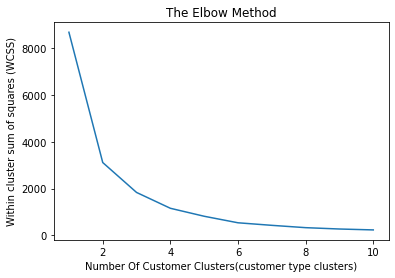

In [53]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X= sc_X.fit_transform(X)
#Using the Elbow method to find the optimum number of clusters
from sklearn.cluster import KMeans
wcss = [] #Within cluster sum of squares (inertia)

# https://stats.stackexchange.com/questions/185396/why-is-k-means-slower-than-random-initialization-k-means/185422
#n_clusters is no.of clusters given by this method,
#k-means++ is an random initialization methods for centriods to avoid random initialisation trap,
#max_iter is max no of iterations defined when k-means is running
#n_init is no of times k-means will run with different initial centroids

for i in range(1,11): #From 2-10 doing multiple random initializations can make a huge difference to find a better local optima
    kmeans = KMeans(n_clusters = i, init ='k-means++',max_iter=300,n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11) , wcss)
plt.title('The Elbow Method')
plt.xlabel('Number Of Customer Clusters(customer type clusters)')
plt.ylabel('Within cluster sum of squares (WCSS)')
plt.show()

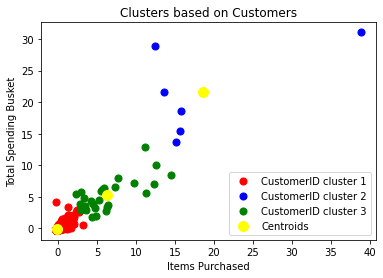

In [54]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 3, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X)

# Visualising the clusters
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 50, c = 'red', label = 'CustomerID cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 50, c = 'blue', label = 'CustomerID cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 50, c = 'green', label = 'CustomerID cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Clusters based on Customers')
plt.xlabel('Items Purchased')
plt.ylabel('Total Spending Busket')
plt.legend()
plt.show()

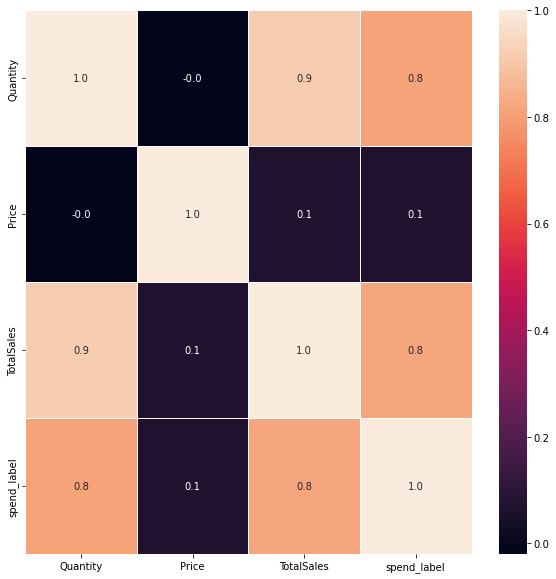

In [55]:
#Data Modeling

# heat map to look for correlation
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax);

# Naive Bayes

C:\Users\STSC\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



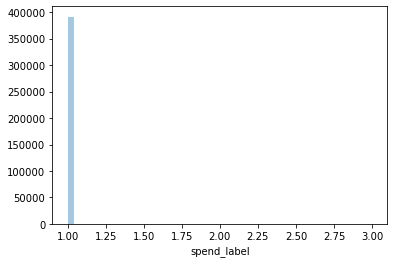

In [56]:
sns.distplot(data['spend_label'],kde = False)
#plt.show()

data2 = data[(data['TotalSales'] >0) & (data['TotalSales'] < 100)]


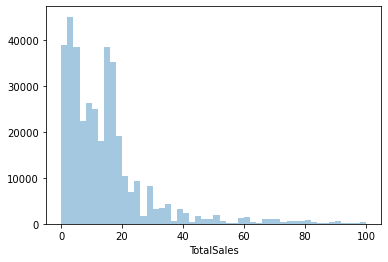

In [57]:
sns.distplot(data2['TotalSales'],kde = False)
plt.show()

In [58]:
spend_label = []
for i in range(0,len(data2),1):
    if data2['TotalSales'].iloc[i] < 10:
        spend_label.append(0)
    elif data2['TotalSales'].iloc[i] >40:
        spend_label.append(2)
    else:
        spend_label.append(1)
data2['spend_label'] = spend_label
data2.shape

C:\Users\STSC\AppData\Local\Temp/ipykernel_10944/1191793013.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(379870, 11)

<AxesSubplot:xlabel='spend_label'>

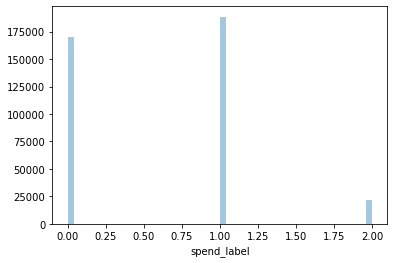

In [59]:
sns.distplot(data2['spend_label'],kde = False)

In [60]:
data2=data2[0:100000]

In [61]:
# encode the description label
cols_to_transform = ['Description']
type_hash = pd.get_dummies(data=data2['Description'])
type_hash2 = pd.get_dummies(data=data2['Country'])

In [62]:
learning_data = pd.concat([data2, type_hash, type_hash2], axis=1)

# drop the columns that have been now been replaced and that are not required
droplist = ['Quantity','StockCode','InvoiceDate','Invoice','Price','Description','time','Country','Customer ID']
learning_data = learning_data.drop(droplist, axis=1)

In [63]:
learning_data = learning_data.reset_index(drop=True)


In [69]:
xdata = learning_data.copy()
del xdata['spend_label']
ydata = learning_data['spend_label']

In [71]:
from sklearn import preprocessing
normalized_xdata = preprocessing.normalize(xdata)

In [72]:
from sklearn import decomposition
from sklearn.decomposition import PCA
scaler = StandardScaler()
scaler.fit(normalized_xdata[:100000])

pca = decomposition.PCA(n_components=5)
pc = pca.fit_transform(normalized_xdata[:100000]) #PCA is being performed on the 1st 100000 data points due to limited compute resource

pc_df = pd.DataFrame(data = pc , 
        columns = ['PC1', 'PC2','PC3','PC4', 'PC5'])
pc_df.head()

,PC1,PC2,PC3,PC4,PC5
0,-0.091839,0.004761,0.000213,0.000224,-0.002363
1,-0.106009,0.012647,0.000239,0.000296,-0.003151
2,-0.109218,0.014389,0.000232,0.000301,-0.003308
3,-0.106008,0.012613,0.000237,0.000293,-0.003130
4,-0.106007,0.012621,0.000238,0.000293,-0.003130


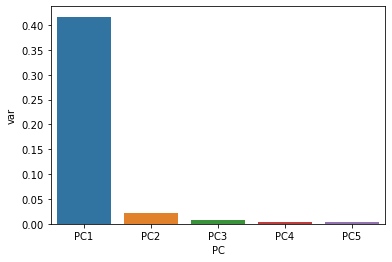

In [73]:
# plot the variance
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':['PC1','PC2','PC3','PC4', 'PC5']})
sns.barplot(x='PC',y="var", 
           data=df);

In [74]:
scaler = StandardScaler()
scaler.fit(xdata[:100000])
X=scaler.transform(xdata[:100000])

pca = PCA(n_components=2)
pca.fit(X,ydata)
x_new = pca.transform(X)

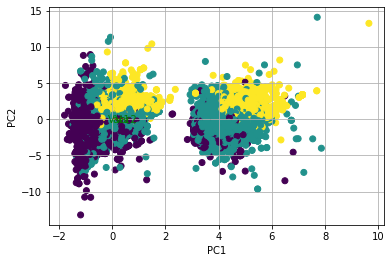

In [75]:
def pca_plot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]

    plt.scatter(xs ,ys, c =ydata[:100000]) #without scaling
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. 
pca_plot(x_new[:,0:2], pca. components_) 
plt.show()

In [76]:
#From the PCA analysis of the dataset, the majority of variance in the model is in the 1st principle component. It is of no great surprise that potentially, total spend is sufficient to predict the basket size label. 
# using 'Country' as label
scaler = StandardScaler()
scaler.fit(xdata[:100000])
X=scaler.transform(xdata[:100000])

pca = PCA(n_components=2)
pca.fit(X,ydata)
x_new = pca.transform(X)

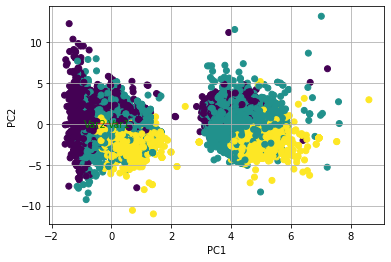

In [77]:
def pca_plot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]

    plt.scatter(xs ,ys, c =ydata[:100000]) #without scaling
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. 
pca_plot(x_new[:,0:2], pca. components_) 
plt.show()

In [78]:
#Data Preparation
# encode the description label
cols_to_transform = ['Description']
type_hash = pd.get_dummies(data=data2['Description'])
learning_data2 = pd.concat([data2, type_hash], axis=1)
learning_data2.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalSales,time,...,YULETIDE IMAGES S/6 PAPER BOXES,ZINC FINISH 15CM PLANTER POTS,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC METAL HEART DECORATION,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,...,0,0,0,0,0,0,0,0,0,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,...,0,0,0,0,0,0,0,0,0,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,...,0,0,0,0,0,0,0,0,0,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,...,0,0,0,0,0,0,0,0,0,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,...,0,0,0,0,0,0,0,0,0,0


In [79]:
# drop the columns that have been now been replaced and that are not required
droplist = ['Quantity','StockCode','InvoiceDate','Invoice','Price','Description','time','spend_label','Customer ID']
learning_data2 = learning_data2.drop(droplist, axis=1)

learning_data2 = learning_data2.reset_index(drop=True)
xdata2 = learning_data2.copy()
del xdata2['Country']
ydata2 = learning_data2['Country']

In [80]:
# convert ydata2 to integer
ydata2 = ydata.astype('category')
normalized_xdata2 = preprocessing.normalize(xdata)

In [81]:
import itertools

# confusion matrix plotting function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [82]:
from sklearn.naive_bayes import GaussianNB #choose model class - done
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,accuracy_score, f1_score
from sklearn.model_selection import  cross_val_score
#from sklearn.externals import joblib #for saving the trained model
nb_model = GaussianNB() #instantiate the model - done (GaussianNB has no hyperparameters)

In [83]:
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
normalized_xdata = preprocessing.normalize(xdata)
xtrain, xtest, ytrain, ytest = train_test_split(normalized_xdata,ydata,test_size = 0.3, random_state = 8418) #70/30 training/test split - standard
nb_model.fit(xtrain, ytrain) #fit the model to the data

GaussianNB()

Accuracy: 62.16%
Recall: 62.163333333333334 %
Precision: 62.163333333333334 %


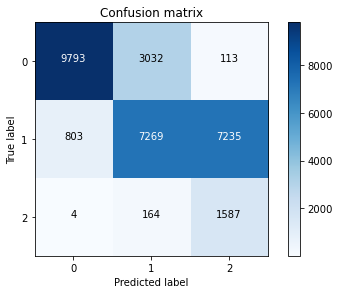

In [84]:
# Use the trained model to predict on the test data
predictions = list(nb_model.predict(xtest))

accuracy = accuracy_score(ytest, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Recall:', recall_score(ytest, predictions,average="micro")*100,"%")
print('Precision:', precision_score(ytest, predictions,average="micro")*100,"%")

dat = confusion_matrix(ytest, predictions)

plot_confusion_matrix(
    dat, classes=[0,1,2], title='Confusion matrix')
plt.show()

In [85]:

xval_score = cross_val_score(nb_model, xtrain, ytrain, cv=5, n_jobs=-1).mean() #5-fold cross validation
xval_score

0.6160857142857143

#The naive bayes model is approximatley 62% accurate in predicting how likely a customer is to be purchasing a low, medium, or high value basket. The model is biased toward the small basket size, presumably due to bias in the training 

# Time Series Analysis

In [86]:
data.set_index('InvoiceDate', inplace=True)

In [87]:
y = data['TotalSales'].resample('D').sum()
y.head()

InvoiceDate
2010-12-01    46085.29
2010-12-02    47164.57
2010-12-03    23530.93
2010-12-04        0.00
2010-12-05    30905.32
Freq: D, Name: TotalSales, dtype: float64

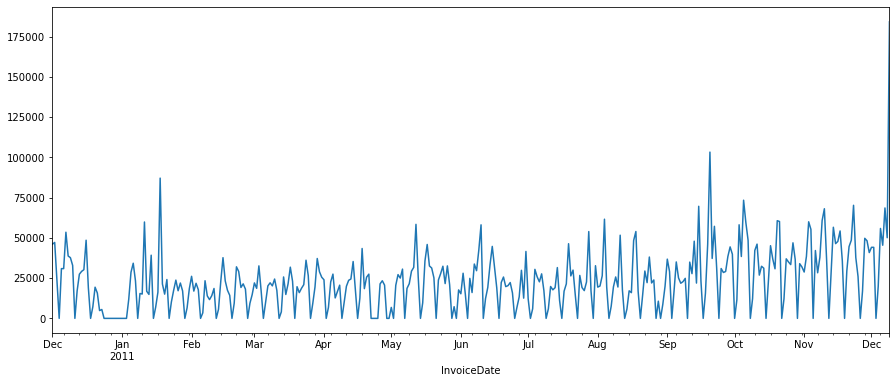

In [88]:
y = y.fillna(y.bfill())
y.plot(figsize=(15,6))
plt.show()

In [89]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

# try adjust the `s` parameter
s = 30
seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]
print('Example of parameter conbination for Seasonal ARIMA')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[2]))

Example of parameter conbination for Seasonal ARIMA
SARIMAX: (0, 0, 1) x (0, 0, 1, 30)
SARIMAX: (0, 1, 0) x (0, 1, 0, 30)


In [90]:
warnings.filterwarnings('ignore')
history = {}
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                           order=param,
                                           seasonal_order=param_seasonal,
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)
            
            results = mod.fit()
            history[(param, param_seasonal)] = results.aic
            print('ARIMA{}x{} - AIC: {}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 30) - AIC: 8759.078197893501
ARIMA(0, 0, 0)x(0, 0, 1, 30) - AIC: 7990.89226471839
ARIMA(0, 0, 0)x(0, 1, 0, 30) - AIC: 7931.683084235465
ARIMA(0, 0, 0)x(0, 1, 1, 30) - AIC: 7146.762459213864
ARIMA(0, 0, 0)x(1, 0, 0, 30) - AIC: 7920.529445014874
ARIMA(0, 0, 0)x(1, 0, 1, 30) - AIC: 7797.977592586114
ARIMA(0, 0, 0)x(1, 1, 0, 30) - AIC: 7202.503746061196
ARIMA(0, 0, 0)x(1, 1, 1, 30) - AIC: 7132.673187233831
ARIMA(0, 0, 1)x(0, 0, 0, 30) - AIC: 8571.836105425717
ARIMA(0, 0, 1)x(0, 0, 1, 30) - AIC: 7871.262632910872
ARIMA(0, 0, 1)x(0, 1, 0, 30) - AIC: 7880.477960553622
ARIMA(0, 0, 1)x(0, 1, 1, 30) - AIC: 7083.848237905647
ARIMA(0, 0, 1)x(1, 0, 0, 30) - AIC: 7900.574568355362
ARIMA(0, 0, 1)x(1, 0, 1, 30) - AIC: 7809.4566604589145
ARIMA(0, 0, 1)x(1, 1, 0, 30) - AIC: 7170.600526375864
ARIMA(0, 0, 1)x(1, 1, 1, 30) - AIC: 7082.452213549377
ARIMA(0, 1, 0)x(0, 0, 0, 30) - AIC: 8446.811265264145
ARIMA(0, 1, 0)x(0, 0, 1, 30) - AIC: 7768.939757008372
ARIMA(0, 1, 0)x(0, 1, 0, 30)

In [91]:
sorted_x = sorted(history.items(), key=operator.itemgetter(1))
param, param_seasonal =  sorted_x[0][0][0], sorted_x[0][0][1]
model = sm.tsa.statespace.SARIMAX(y,
                         order = param,
                         seasonal_order=param_seasonal,
                         enforce_stationarity=False,
                         enforce_invertibility=False)

results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         TotalSales   No. Observations:                  374
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 30)   Log Likelihood               -3535.258
Date:                            Thu, 02 Dec 2021   AIC                           7080.517
Time:                                    10:40:41   BIC                           7099.232
Sample:                                12-01-2010   HQIC                          7087.996
                                     - 12-09-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3541      0.197      1.795      0.073      -0.033       0.741
ma.L1          0.1391      0.204   

# Forecasting (Train data taken from last 6 months of the year 2011) 

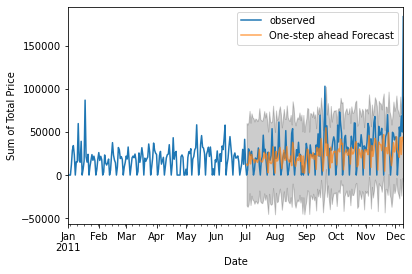

In [92]:
start_date = '2011-07-02'
pred = results.get_prediction(start=pd.to_datetime(start_date), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2011':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1], color='k',
               alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sum of Total Price')

plt.legend()

plt.show()

In [93]:
y_forecasted = pred.predicted_mean
y_truth = y[start_date:]

mse = ((y_forecasted - y_truth) ** 2).mean()

print('The Mean Squared Error of our forecasts is {}'.format(round(mse,2))) 


The Mean Squared Error of our forecasts is 532699267.15


In [94]:
pred_dynamic = results.get_prediction(start=pd.to_datetime(start_date), dynamic=True)

pred_dynamic_ci = pred_dynamic.conf_int()
y_forecasted = pred_dynamic.predicted_mean
y_truth = y[start_date:]
mse = ((y_forecasted - y_truth) ** 2).mean()

print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 707820568.36


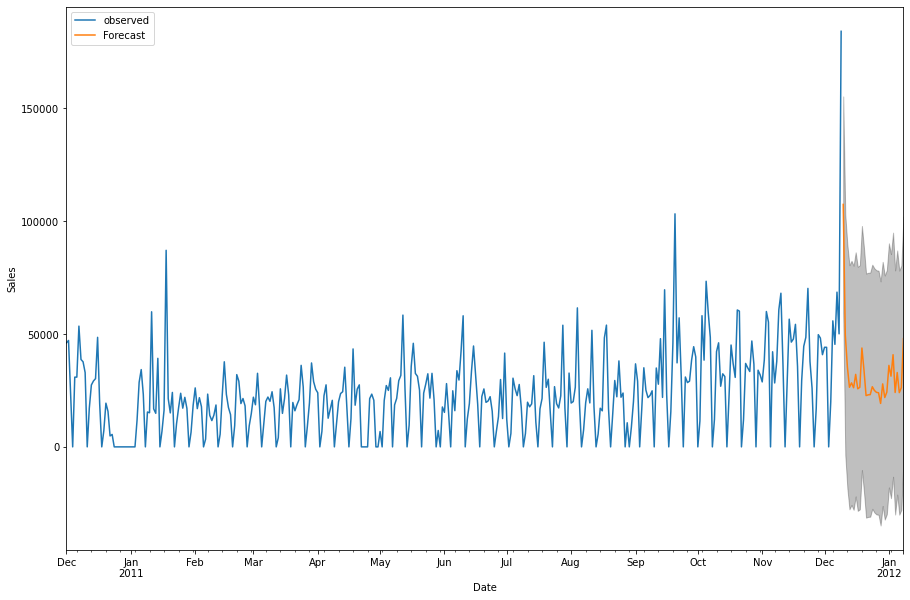

In [95]:
pred_uc = results.get_forecast(steps=30)

pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(15,10))

pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1],
               color='k',
               alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

Here, we can see that the root mean square error (rmse) value for our seasonal naive method is the moderate among all. Even from the graph, we are able to view that the predictions fit the test data well.